# Sleep Prediction

In this notebook we attempt to predict the specific timesteps for both sleep onsets and wakeup for each user on every night.

Much of the code in this notebook was taken and refactored to pandas from this original [notebook](https://www.kaggle.com/code/zhukovoleksiy/detect-sleep-states-baseline-solution/notebook). 

# Imports, Load data

In [1]:
# load in score function
from metric import score

# helper.py
from helper import *

In [1]:
# read in the data
root = 'data/'
# data = pd.read_parquet(root + 'train_series.parquet')
# events = pd.read_csv(root + 'train_events.csv')
# test = pd.read_parquet(root + 'test_series.parquet')

# load with polars
data = pl.read_parquet(root + 'train_series.parquet')
events = pl.read_csv(root + 'train_events.csv')
test = pl.read_parquet(root + 'test_series.parquet')

NameError: name 'pl' is not defined

In [ ]:
# format columns
for df in [data, test]:
    # datetime transforms
    df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute

    # cast enmo to unsigned int
    df['enmo'] = (df['enmo'] * 1000).astype('uint16')

    # cast anglez to int
    df['anglez'] = df['anglez'].astype('int8')

In [23]:
# getting series ids as a list
series_ids = events['series_id'].unique().tolist()
print(f'Number of total series: {len(series_ids)}')

# get counts of onset and wakeup for each user
onset_counts = events.query('event == "onset"').dropna().groupby('series_id').size()
wakeup_counts = events.query('event == "wakeup"').dropna().groupby('series_id').size()

# create counts df and get the mismatches
counts = pd.DataFrame({'onset_counts': onset_counts, 'wakeup_counts': wakeup_counts}).reset_index()
count_mismatches = counts.query('onset_counts != wakeup_counts')

# removing users with mismatched onset/wakeup counts
data_dropped = data[~data['series_id'].isin(count_mismatches['series_id'])]
events_dropped = events[~events['series_id'].isin(count_mismatches['series_id'])]

# update list of series ids, not including series with no non-null values
series_ids_dropped = events_dropped['series_id'].unique().tolist()
print(f'Number of series after removing mismatched counts: {len(series_ids_dropped)}')

Number of total series: 277
Number of series after removing mismatched counts: 272


# Split data
- Dataset is quite large. We implement a function to train on a subset.

In [30]:
# function that gets a random subset of 'n' series ids, returns train and val subsets
def get_train_val(series, n=10, random_state=SEED):
    # get series ids
    series_ids = series['series_id'].drop_duplicates().tolist()
    train_ids = np.random.choice(series_ids, n, replace=False)
    val_ids = np.random.choice([i for i in series_ids if i not in train_ids], n, replace=False)

    # get subsets
    train_subset = series[series['series_id'].isin(train_ids)]
    val_subset = series[series['series_id'].isin(val_ids)]
    return train_subset, val_subset

# get train and val subsets
train_subset, val_subset = get_train_val(series=data)

# check shapes
print(f'Train subset num series_ids: {train_subset.series_id.nunique()}, shape: {train_subset.shape}')
print(f'Val subset num series_ids: {val_subset.series_id.nunique()}, shape: {val_subset.shape}')

Train subset num series_ids: 10, shape: (4594680, 5)
Val subset num series_ids: 10, shape: (5086980, 5)


In [31]:
train_subset

,series_id,step,timestamp,anglez,enmo
21706740,292a75c0b94e,0,2019-03-14T13:15:00-0500,-25.951500,0.0014
21706741,292a75c0b94e,1,2019-03-14T13:15:05-0500,-43.377201,0.0269
21706742,292a75c0b94e,2,2019-03-14T13:15:10-0500,-54.987099,0.0352
21706743,292a75c0b94e,3,2019-03-14T13:15:15-0500,-40.026100,0.0704
21706744,292a75c0b94e,4,2019-03-14T13:15:20-0500,-16.974701,0.1318
...,...,...,...,...,...
98117095,cf13ed7e457a,639895,2018-06-28T13:14:35-0400,-38.240700,0.0413
98117096,cf13ed7e457a,639896,2018-06-28T13:14:40-0400,7.491100,0.0383
98117097,cf13ed7e457a,639897,2018-06-28T13:14:45-0400,7.924200,0.0670
98117098,cf13ed7e457a,639898,2018-06-28T13:14:50-0400,-8.983900,0.0971


# Feature Engineering

In [ ]:
def create_features(df):
    """
    Create features for each series.

    Args:
    - df (pd.DataFrame): Contains the series data with columns 'enmo', 'anglez'

    Returns:
    - pd.DataFrame: DataFrame with new features added.
    """

    def max_consecutive_flat(x, epsilon=0.01):
        """
        Given an array of values (for example, anglez_diff), this helper function
        returns the maximum run-length (i.e. the maximum number of consecutive elements)
        for which x is below a threshold (epsilon).
        
        Args:
        - x (np.array): array of difference values.
        - epsilon (float): Threshold below which a value is considered "flat".
        
        Returns:
        - int: maximum number of consecutive "flat" values in x.
        """

        is_flat = (x < epsilon)
        max_run = 0
        current_run = 0
        for val in is_flat:
            if val:
                current_run += 1
            else:
                max_run = max(max_run, current_run)
                current_run = 0
        max_run = max(max_run, current_run)
        return max_run

    def proportion_below_threshold(x, threshold=0.1):
        """
        Computes the proportion of values in the array x that are below the given threshold.
        
        Args:
        - x (np.array): array of enmo values.
        - threshold (float): threshold value for enmo.
        
        Returns:
        - float: proportion of values below the threshold.
        """

        return np.mean(x < threshold)
    
    # avoid modifying the original DataFrame
    df = df.copy()

    # compute difference features as absolute diff - fill first NaN with 0.
    df['enmo_diff'] = df['enmo'].diff().abs().fillna(0).astype('uint8')
    df['anglez_diff'] = df['anglez'].diff().abs().fillna(0).astype('uint8')

    # list of windows in minutes
    windows = [1, 3, 5, 7.5, 10, 12.5, 15, 20, 25, 30, 60, 120, 240, 480]

    # loop over each window duration, creating rolling features
    for m in tqdm(windows, desc="Creating rolling features"):
        # number of 5-sec intervals
        window_size = m * 12

        # create rolling features for each column
        for col in ['enmo', 'anglez']:
            # rolling features of the original signal
            df[f'{col}_{m}m_mean'] = df[col].rolling(window_size, center=True, min_periods=1).mean().abs().astype('uint8')
            df[f'{col}_{m}m_max'] = df[col].rolling(window_size, center=True, min_periods=1).max().abs().astype('uint8')
            df[f'{col}_{m}m_min'] = df[col].rolling(window_size, center=True, min_periods=1).min().abs().astype('uint8')
            df[f'{col}_{m}m_std'] = df[col].rolling(window_size, center=True, min_periods=1).std().fillna(0).astype('uint8')

            # rolling mean and max for the signal's diff (captures volatility)
            diff_col = f'{col}_diff'
            df[f'{col}_{m}m_mean'] = df[diff_col].rolling(window_size, center=True, min_periods=1).mean().astype('uint8')
            df[f'{col}_{m}m_max'] = df[diff_col].rolling(window_size, center=True, min_periods=1).max().astype('uint8')
            df[f'{col}_{m}m_std'] = df[diff_col].rolling(window_size, center=True, min_periods=1).std().fillna(0).astype('uint8')
    
        # using the anglez_diff, how long of a continuous flat segment exists in the window
        df[f'anglez_flat_run_{m}m'] = df['anglez_diff'].rolling(window_size, center=True, min_periods=1)\
                                                .apply(lambda x: max_consecutive_flat(x, epsilon=0.01), raw=True)
        
        # proportion of enmo values below 0.1 in the window
        df[f'enmo_thresh_prop_{m}m'] = df['enmo'].rolling(window_size, center=True, min_periods=1)\
                                                .apply(lambda x: proportion_below_threshold(x, threshold=0.1), raw=True).astype('float32')

    return df

You can see above that we took the absolute value for changes in both the enmo and anglez columns. If you look at the variation of both features in the [EDA](./eda.ipynb), you see that positive/negative change do not matter, but the __magnitude__ of that change.

In [ ]:
# create features
X_train = create_features(train_subset)
X_val = create_features(val_subset)

# shapes
print(f'Train subset shape: {X_train.shape}')
print(f'Val subset shape: {X_val.shape}')

100%|██████████| 4/4 [00:05<00:00,  1.34s/it]

Train subset shape: (5015340, 40)
Val subset shape: (4269420, 40)


In [ ]:
# look at new features
X_train.head()

,series_id,step,timestamp,anglez,enmo,hour,enmo_diff,anglez_diff,enmo_5m_mean,enmo_5m_max,anglez_5m_mean,anglez_5m_max,enmo_1v_5m_mean,enmo_1v_5m_max,anglez_1v_5m_mean,anglez_1v_5m_max,enmo_30m_mean,enmo_30m_max,anglez_30m_mean,anglez_30m_max,enmo_1v_30m_mean,enmo_1v_30m_max,anglez_1v_30m_mean,anglez_1v_30m_max,enmo_120m_mean,enmo_120m_max,anglez_120m_mean,anglez_120m_max,enmo_1v_120m_mean,enmo_1v_120m_max,anglez_1v_120m_mean,anglez_1v_120m_max,enmo_480m_mean,enmo_480m_max,anglez_480m_mean,anglez_480m_max,enmo_1v_480m_mean,enmo_1v_480m_max,anglez_1v_480m_mean,anglez_1v_480m_max
7216920,0ef7d94fde99,0,2018-01-26 22:30:00+00:00,34.612598,0.0266,22,0,0,0,1,4,67,0,0,18,94,0,1,4,67,0,0,12,94,0,1,6,69,0,0,10,94,0,1,13,69,0,1,7,94
7216921,0ef7d94fde99,1,2018-01-26 22:30:05+00:00,47.057598,0.0277,22,0,12,0,1,4,67,0,0,17,94,0,1,4,67,0,0,12,94,0,1,6,69,0,0,10,94,0,1,13,69,0,1,7,94
7216922,0ef7d94fde99,2,2018-01-26 22:30:10+00:00,62.150902,0.0205,22,0,15,0,1,3,67,0,0,18,94,0,1,4,67,0,0,12,94,0,1,6,69,0,0,10,94,0,1,13,69,0,1,7,94
7216923,0ef7d94fde99,3,2018-01-26 22:30:15+00:00,67.852699,0.0312,22,0,5,0,1,3,67,0,0,18,94,0,1,4,67,0,0,12,94,0,1,6,69,0,0,10,94,0,1,13,69,0,1,7,94
7216924,0ef7d94fde99,4,2018-01-26 22:30:20+00:00,66.735497,0.0306,22,0,1,0,1,3,67,0,0,19,94,0,1,4,67,0,0,12,94,0,1,6,69,0,0,10,94,0,1,13,69,0,1,7,94


__3__ id cols + __37__ features

# Create Labels

In [10]:
# classify columns into id and features
id_cols = ['series_id', 'step', 'timestamp']
feature_cols = [col for col in train_subset.columns if col not in id_cols]

In [11]:
def make_train_dataset(train_series, train_events, drop_nulls=True):
    """
    Normalize features (with respect to each user) and create labels for training data.
    """

    # get all series ids of the series
    series_ids = train_series['series_id'].unique().tolist()

    # Initialize the dataframe for features and labels
    X = pd.DataFrame()
    y = pd.DataFrame()

    # iterate through each user
    for idx in tqdm(series_ids): 
        # get data for the user
        sample = train_series[train_series['series_id'] == idx].copy()

        # normalize features bydividing by the standard deviation
        for col in feature_cols:
            if (col != 'hour') & (sample[col].std() != 0):
                sample[col] = sample[col] / sample[col].std()

        # get events for the user
        events = train_events[train_events['series_id'] == idx]

        # remove datapoints on dates where no event was recorded
        if drop_nulls:
            valid_dates = events['timestamp'].dt.date.unique()
            sample = sample[sample['timestamp'].dt.date.isin(valid_dates)]

        # append user's data to the full dataset
        X = pd.concat([X, sample[id_cols + feature_cols]])

        # get onsets and wakeups
        onsets = events[events['event'] == 'onset']['step'].tolist()
        wakeups = events[events['event'] == 'wakeup']['step'].tolist()

        # create 'asleep' column
        y_series = pd.Series(0, index=sample.index)
        for onset, wakeup in zip(onsets, wakeups):
            # set asleep to 1 between onset and wakeup
            y_series[(sample['step'] >= onset) & (sample['step'] < wakeup)] = 1
        
        # append user's labels to previous labels
        y = pd.concat([y, y_series])

    # flatten y to a 1D array
    y = y.to_numpy().ravel()

    return X, y


In [12]:
# create features and target
X_train, y_train = make_train_dataset(train_subset, train_events)
X_val, y_val = make_train_dataset(val_subset, train_events)

# check shapes
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')

100%|██████████| 10/10 [00:10<00:00,  1.01s/it]

X_train shape: (3383460, 40)
y_train shape: (3383460,)
X_val shape: (2813940, 40)
y_val shape: (2813940,)


In [ ]:
# recover memory

# del data
# del events
# gc.collect()

# Logistic Regression

In [14]:
# create logreg, fit
logreg = LogisticRegression(random_state=random_state, n_jobs=-1)
logreg.fit(X_train.drop(id_cols, axis=1), y_train)

LogisticRegression(n_jobs=-1, random_state=0)

In [15]:
# get train and val predictions
train_preds = logreg.predict(X_train.drop(id_cols, axis=1))
val_preds = logreg.predict(X_val.drop(id_cols, axis=1))

In [17]:
X_train

,series_id,step,timestamp,anglez,enmo,hour,enmo_diff,anglez_diff,enmo_5m_mean,enmo_5m_max,anglez_5m_mean,anglez_5m_max,enmo_1v_5m_mean,enmo_1v_5m_max,anglez_1v_5m_mean,anglez_1v_5m_max,enmo_30m_mean,enmo_30m_max,anglez_30m_mean,anglez_30m_max,enmo_1v_30m_mean,enmo_1v_30m_max,anglez_1v_30m_mean,anglez_1v_30m_max,enmo_120m_mean,enmo_120m_max,anglez_120m_mean,anglez_120m_max,enmo_1v_120m_mean,enmo_1v_120m_max,anglez_1v_120m_mean,anglez_1v_120m_max,enmo_480m_mean,enmo_480m_max,anglez_480m_mean,anglez_480m_max,enmo_1v_480m_mean,enmo_1v_480m_max,anglez_1v_480m_mean,anglez_1v_480m_max
7218000,0ef7d94fde99,1080,2018-01-27 00:00:00+00:00,0.345,0.625,0,0.001,0.000,0.602,0.508,0.898,1.927,2.718,4.197,0.754,1.236,1.700,1.157,0.486,2.588,2.828,14.117,1.264,2.378,2.379,2.118,0.624,5.782,3.018,65535.000,1.846,3.203,2.661,1.873,1.982,18.205,3.347,65535,2.030,7.351
7218001,0ef7d94fde99,1081,2018-01-27 00:00:05+00:00,0.374,0.268,0,2.135,0.089,0.625,0.508,0.842,1.927,2.718,4.197,0.754,1.236,1.670,1.157,0.486,2.588,2.844,14.117,1.264,2.378,2.379,2.118,0.624,5.782,3.022,65535.000,1.846,3.203,2.661,1.873,1.982,18.205,3.347,65535,2.030,7.351
7218002,0ef7d94fde99,1082,2018-01-27 00:00:10+00:00,0.575,0.217,0,2.136,0.620,0.649,0.508,0.786,1.927,2.718,4.197,0.754,1.236,1.700,1.157,0.486,2.588,2.844,14.117,1.264,2.378,2.379,2.118,0.624,5.782,3.022,65535.000,1.846,3.203,2.661,1.873,1.982,18.205,3.348,65535,2.030,7.351
7218003,0ef7d94fde99,1083,2018-01-27 00:00:15+00:00,0.547,0.599,0,0.001,0.089,0.625,0.508,0.786,1.927,2.809,4.197,0.565,1.236,1.700,1.157,0.486,2.588,2.844,14.117,1.264,2.378,2.379,2.118,0.624,5.782,3.018,65535.000,1.846,3.203,2.661,1.873,1.982,18.205,3.347,65535,2.030,7.351
7218004,0ef7d94fde99,1084,2018-01-27 00:00:20+00:00,0.345,0.548,0,2.136,0.620,0.649,0.508,0.786,1.927,2.718,4.197,0.565,0.936,1.700,1.157,0.486,2.588,2.828,14.117,1.264,2.378,2.379,2.118,0.624,5.782,3.018,65535.000,1.846,3.203,2.661,1.873,1.982,18.205,3.346,65535,2.030,7.351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123779515,f7eb179216c2,385555,2018-02-21 23:59:35+00:00,-0.247,0.619,23,0.000,0.233,1.133,0.294,0.249,0.279,2.216,3.448,0.457,0.316,1.432,0.249,0.594,4.009,2.771,8.985,0.510,3.160,1.492,1.244,1.247,5.339,2.347,1061489.074,0.752,5.516,1.992,1.054,1.090,10.180,3.501,65535,1.436,6.696
123779516,f7eb179216c2,385556,2018-02-21 23:59:40+00:00,-0.356,1.069,23,0.002,0.310,1.133,0.294,0.249,0.279,2.216,3.448,0.457,0.316,1.432,0.249,0.594,4.009,2.771,8.985,0.510,3.160,1.492,1.244,1.247,5.339,2.351,1061489.074,0.752,5.516,1.992,1.054,1.090,10.180,3.501,65535,1.436,6.696
123779517,f7eb179216c2,385557,2018-02-21 23:59:45+00:00,-0.301,0.925,23,2.145,0.155,1.133,0.294,0.249,0.279,2.216,3.448,0.457,0.316,1.432,0.249,0.654,4.009,2.787,8.985,0.510,3.160,1.466,1.244,1.247,5.339,2.356,1061489.074,0.752,5.516,1.992,1.054,1.090,10.180,3.502,65535,1.436,6.696
123779518,f7eb179216c2,385558,2018-02-21 23:59:50+00:00,-0.411,0.747,23,2.145,0.310,1.133,0.294,0.249,0.279,2.216,3.448,0.457,0.316,1.452,0.249,0.654,4.009,2.803,8.985,0.510,3.160,1.466,1.244,1.247,5.339,2.356,1061489.074,0.752,5.516,1.992,1.054,1.090,10.180,3.504,65535,1.436,6.696


              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96   2178900
         1.0       0.92      0.95      0.94   1204560

    accuracy                           0.95   3383460
   macro avg       0.95      0.95      0.95   3383460
weighted avg       0.96      0.95      0.96   3383460



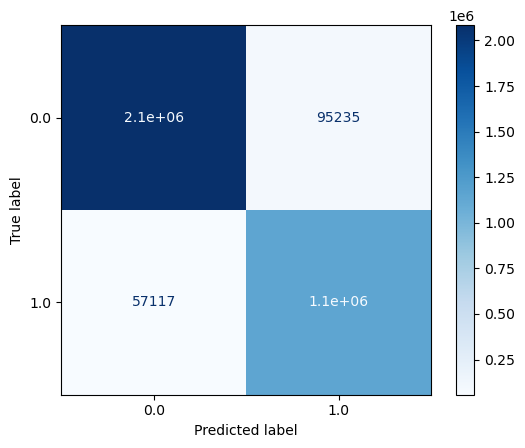

In [18]:
# look at training performance
ConfusionMatrixDisplay.from_estimator(logreg, X_train.drop(id_cols, axis=1), y_train, cmap='Blues');
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96   1771932
         1.0       0.93      0.94      0.94   1042008

    accuracy                           0.95   2813940
   macro avg       0.95      0.95      0.95   2813940
weighted avg       0.95      0.95      0.95   2813940



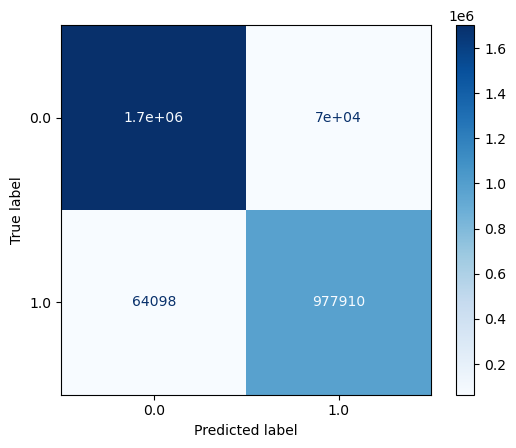

In [19]:
# look at validation performance
ConfusionMatrixDisplay.from_estimator(logreg, X_val.drop(id_cols, axis=1), y_val, cmap='Blues');
print(classification_report(y_val, val_preds))

- With only training a untuned Logistic Regression on 10 samples, our model was able to classify the validation data with __95%__ accuracy.
- Next, we will predict onset and wakeup for the validation data.

# Predict Onset and Wakeup on Validation Data

In [20]:
def get_events(series, classifier):
    '''
    Takes a time series and a classifier and returns a formatted submission dataframe.

    Inputs:
    - series: DataFrame containing series data
    - classifier: trained classifier

    Outputs:
    - events: DataFrame containing sleep events

    '''



    # get unique series ids
    series_ids = series['series_id'].unique()

    # create empty events df
    events = pd.DataFrame(columns=['series_id', 'step', 'event', 'score', 'date'])

    # iterate through each user
    for idx in tqdm(series_ids):
        # normalization and feature selection
        scaled_cols = [col for col in feature_cols if (col != 'hour') & (series[col].std() != 0)]
        X = series[series['series_id'] == idx][id_cols + feature_cols]
        X[scaled_cols] = X[scaled_cols].apply(lambda col: col / series[col.name].std())

        # predictions
        preds, probs = classifier.predict(X[feature_cols]), classifier.predict_proba(X[feature_cols])[:, 1]

        # add cols to X
        X['prediction'] = preds
        X['probability'] = probs

        # identifying sleep events -> when model's prediction changes
        pred_onsets = X[X['prediction'].diff() > 0]['step']
        pred_wakeups = X[X['prediction'].diff() < 0]['step']

        # event processing logic
        if len(pred_onsets) > 0:
            # if first predicted wakeup is before first predicted onset, remove
            if pred_wakeups.iloc[0] < pred_onsets.iloc[0]:
                pred_wakeups = pred_wakeups.iloc[1:]

            # if last predicted onset is after last predicted wakeup, remove
            if pred_onsets.iloc[-1] > pred_wakeups.iloc[-1]:
                pred_onsets = pred_onsets.iloc[:-1]

            # create 'sleep_period' if predicted sleep is greater than 30 minutes
            sleep_periods = [(onset, wakeup) for onset, wakeup in zip(pred_onsets, pred_wakeups) if wakeup - onset >= (30 * 12)]

            # constructing events df
            for onset, wakeup in sleep_periods:
                # score is the average probability of the sleep period
                score = X[(X['step'] >= onset) & (X['step'] < wakeup)]['probability'].mean()

                # get date
                onset_date = X[X['step'] == onset]['timestamp'].dt.date.iloc[0]
                wakeup_date = X[X['step'] == wakeup]['timestamp'].dt.date.iloc[0]

                # add rows to events df
                events.loc[events.shape[0]] = [idx, onset, 'onset', score, onset_date]
                events.loc[events.shape[0]] = [idx, wakeup, 'wakeup', score, wakeup_date]

    # reset index for row ID
    events.reset_index(inplace=True)
    events.rename(columns={'index': 'row_id'}, inplace=True)

    return events

In [21]:
val_event_preds = get_events(val_subset, logreg)

100%|██████████| 10/10 [00:38<00:00,  3.85s/it]


# Score on Validation Data
- Use 'score' function from [metric.py](metric.py) file.

In [35]:
val_event_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   row_id     1246 non-null   int64  
 1   series_id  1246 non-null   object 
 2   step       1246 non-null   int64  
 3   event      1246 non-null   object 
 4   score      1246 non-null   float64
 5   date       1246 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 58.5+ KB


In [39]:
# get labels for validation set
val_labels = train_events[train_events['series_id'].isin(val_subset['series_id'].unique())][['series_id', 'step', 'event']]

# args for scoring function
tolerances = {
    "onset": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360],
    "wakeup": [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
}
series_id_column_name = 'series_id'
time_column_name = 'step'
event_column_name = 'event'
score_column_name = 'score'
use_scoring_intervals = None

# get score
score(val_event_preds.drop(['row_id', 'date'], axis=1), val_labels, tolerances, series_id_column_name, time_column_name, event_column_name, score_column_name, use_scoring_intervals)

NameError: name 'target_name' is not defined

## Visualize
Look at where our model is predicting onset and wakeup and compare to the true labels.

C:\Users\heefj\AppData\Local\Temp\ipykernel_23736\1298505174.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_example['date'] = val_example['timestamp'].dt.date


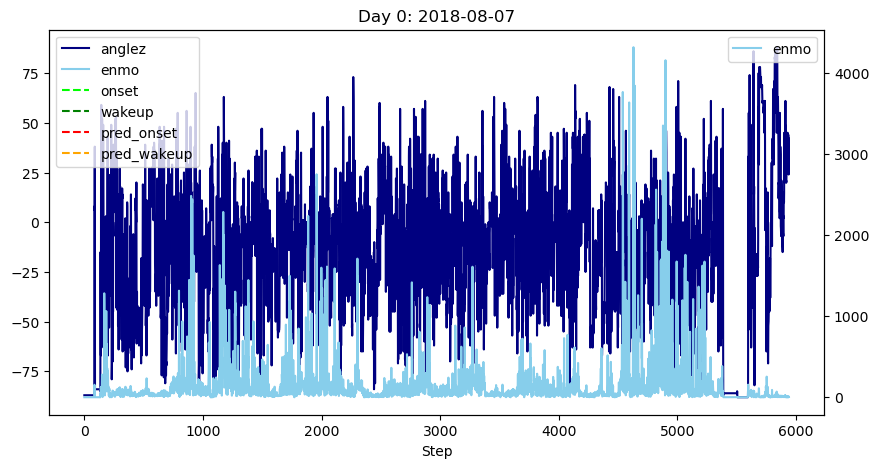

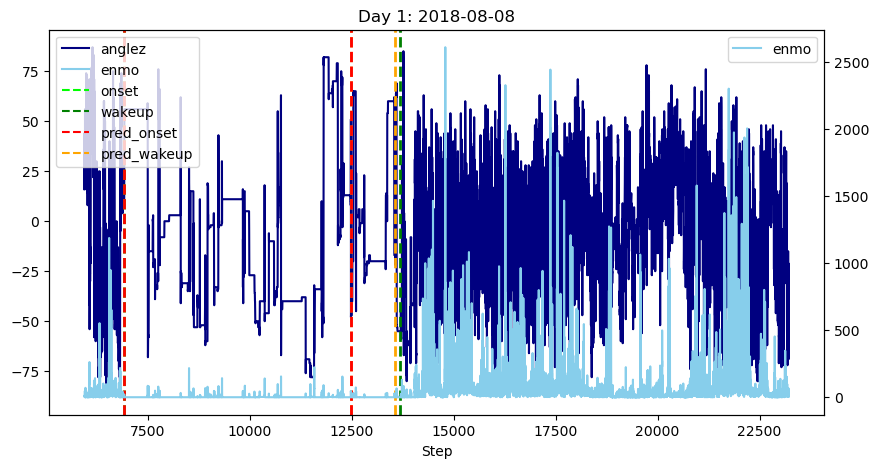

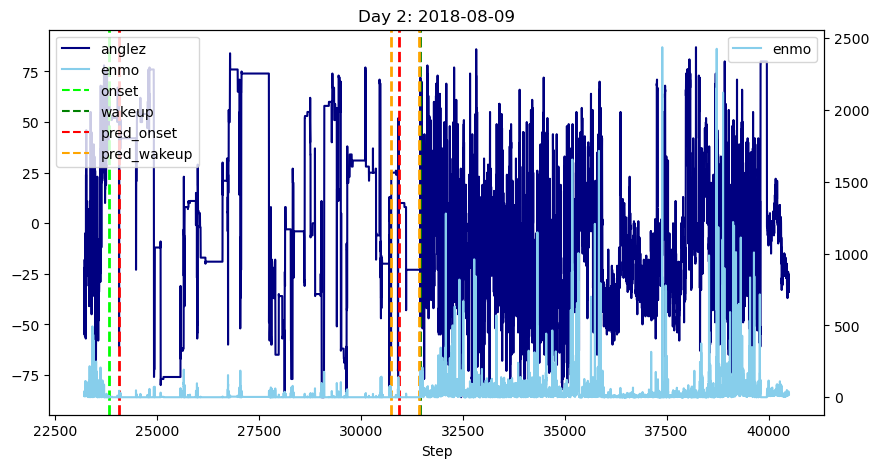

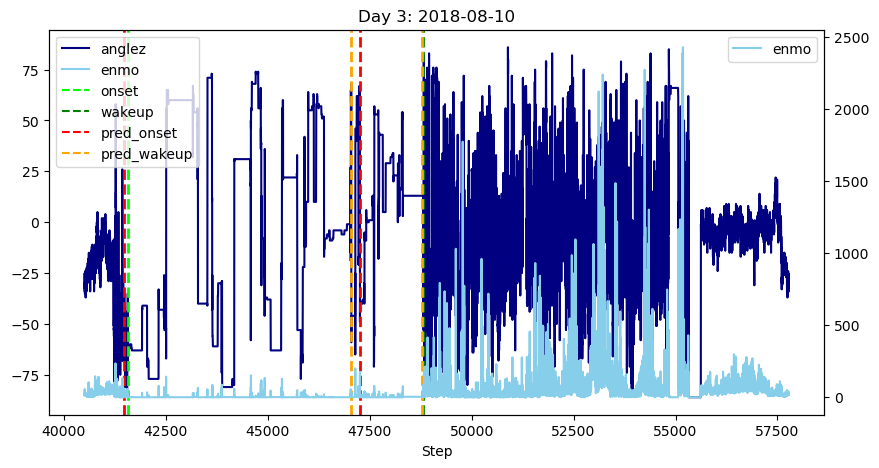

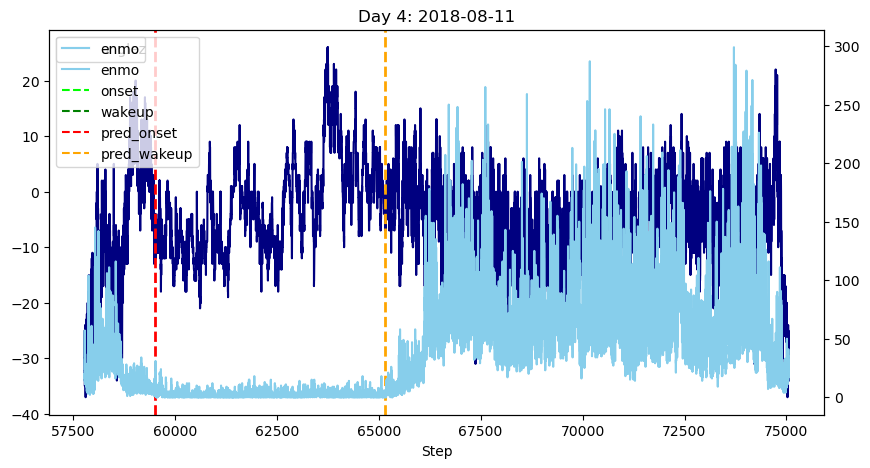

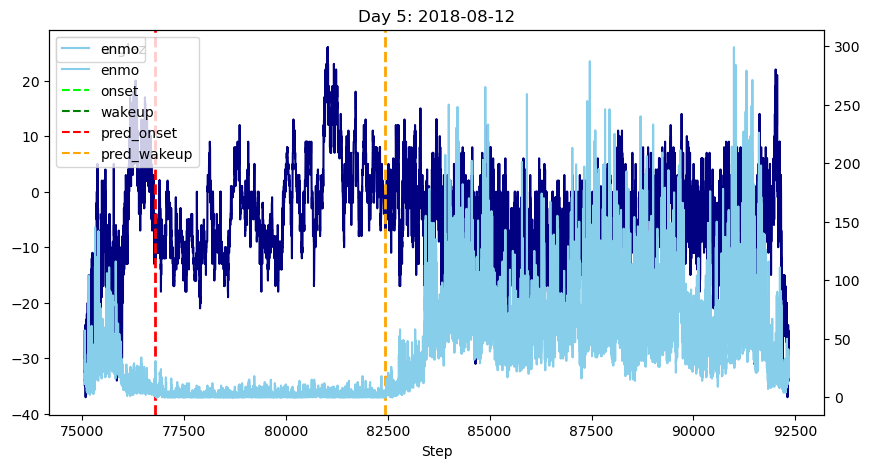

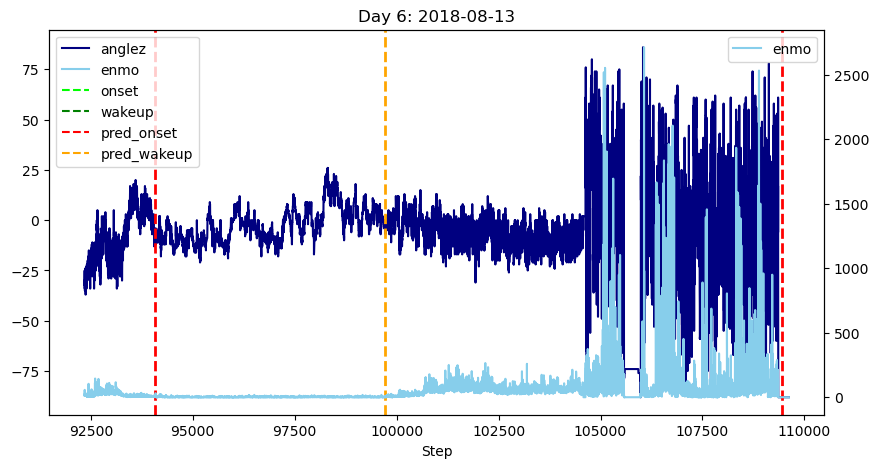

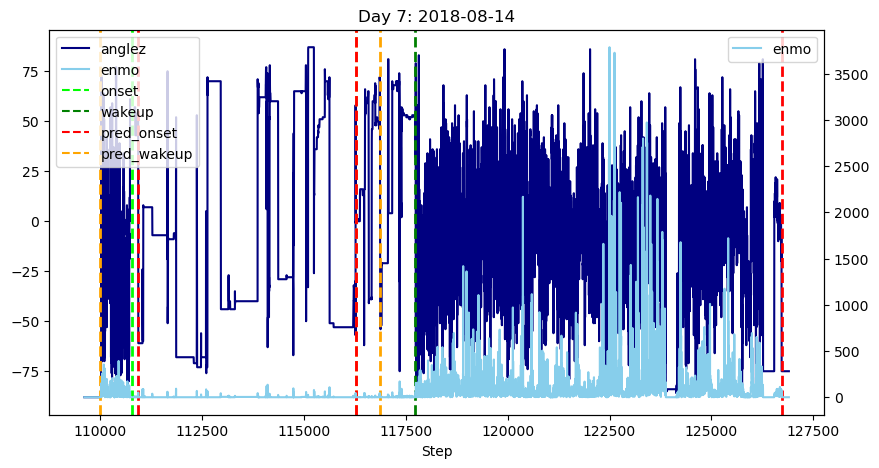

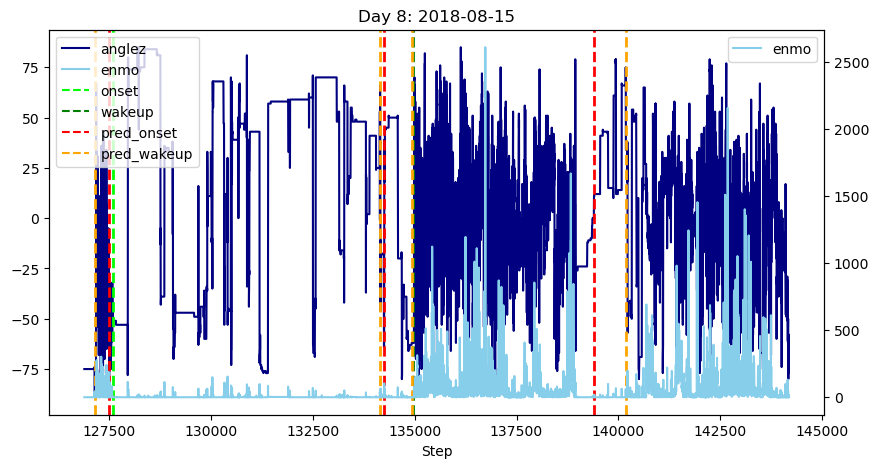

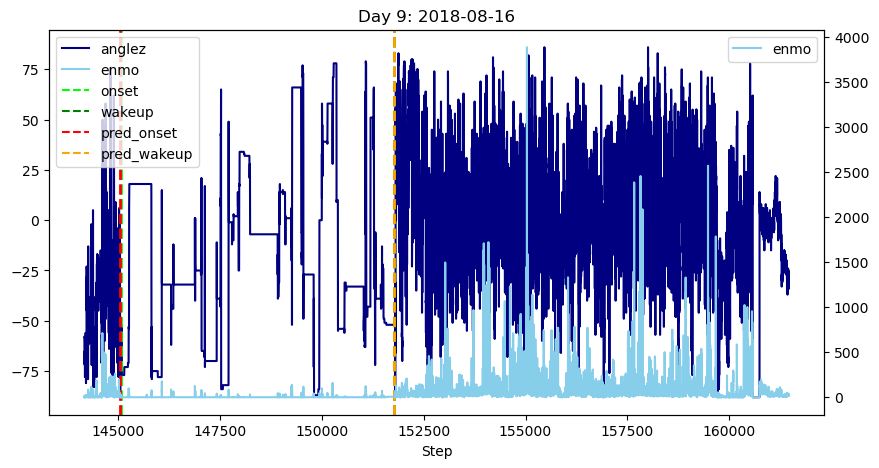

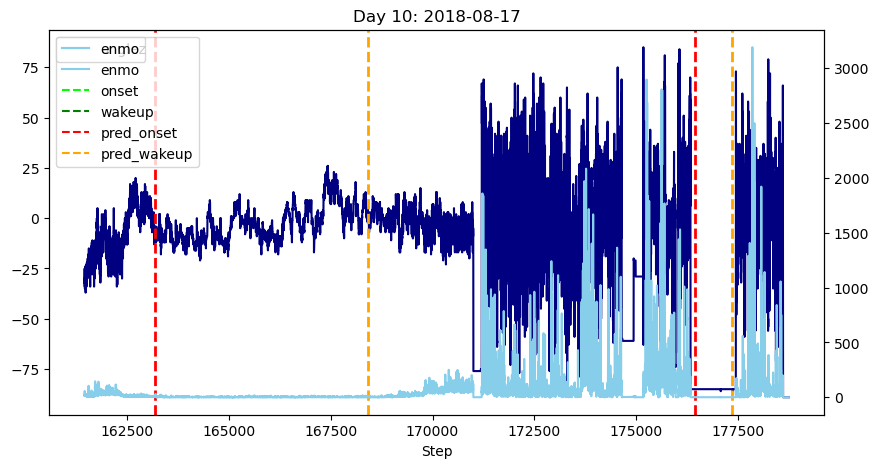

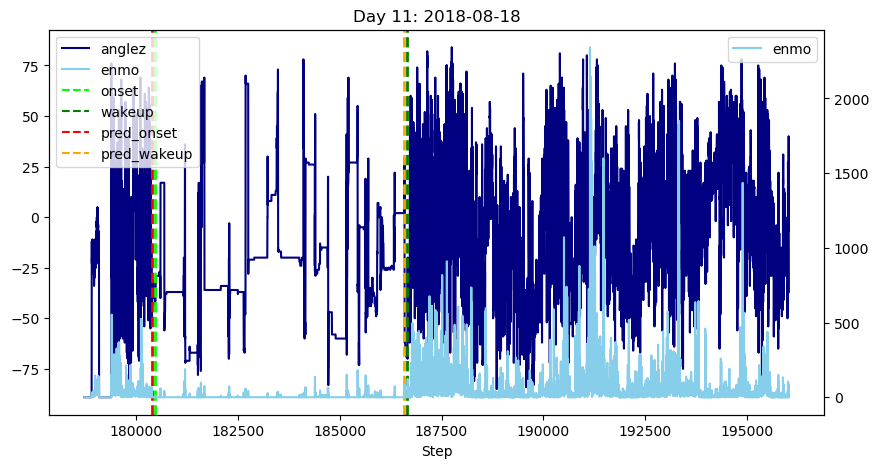

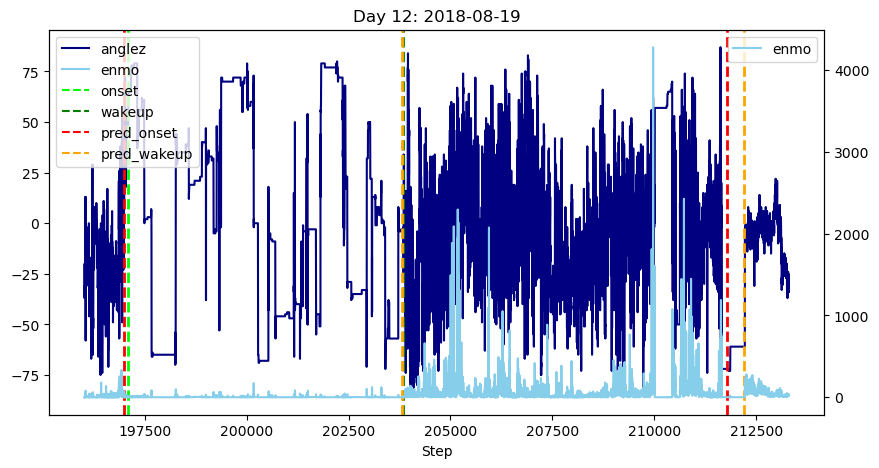

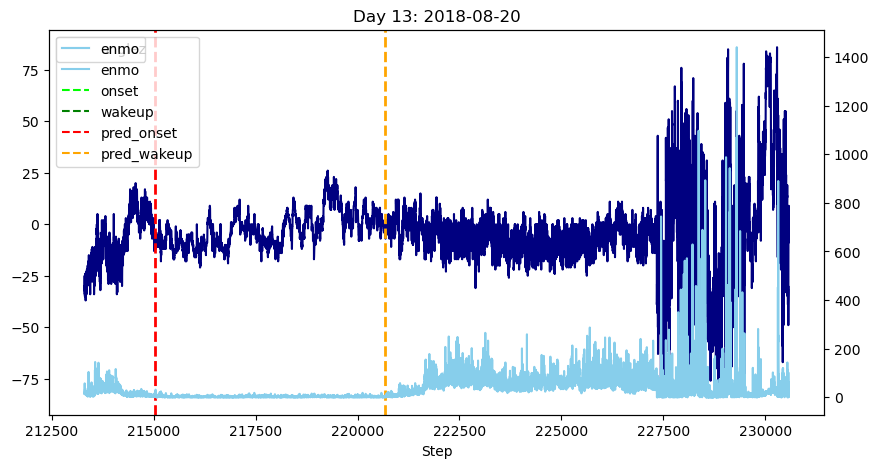

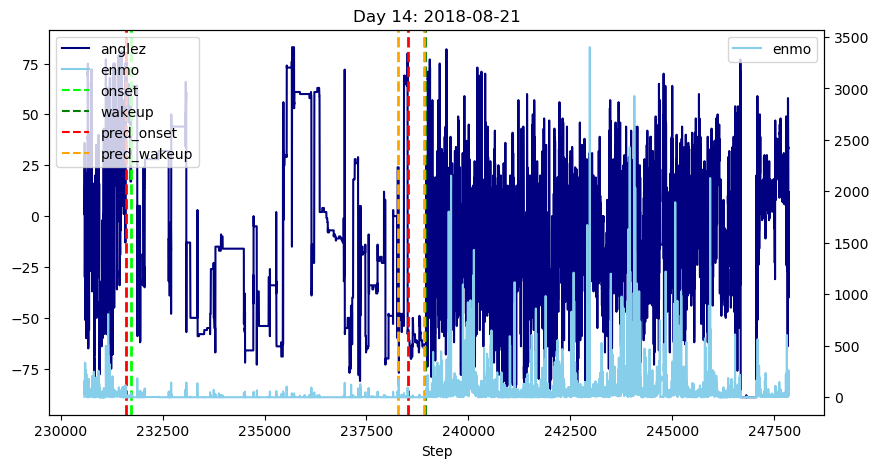

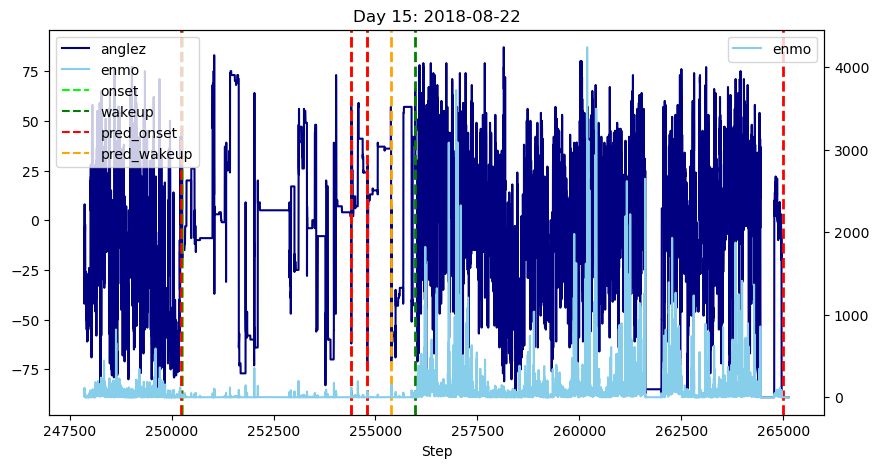

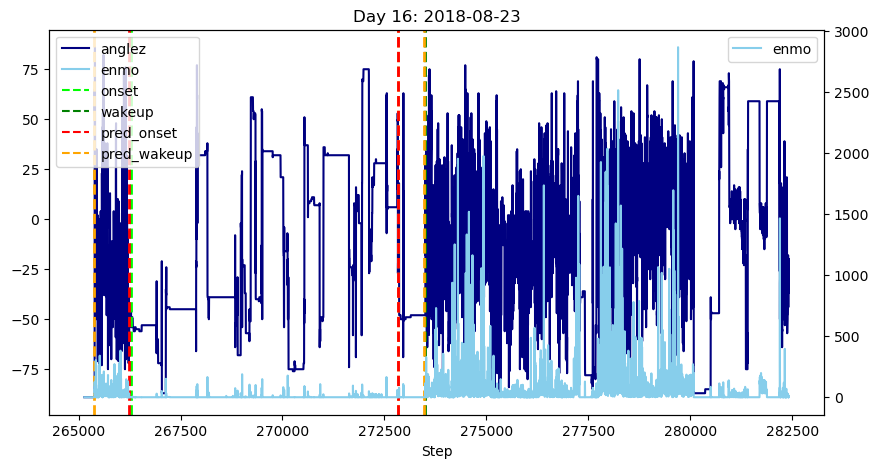

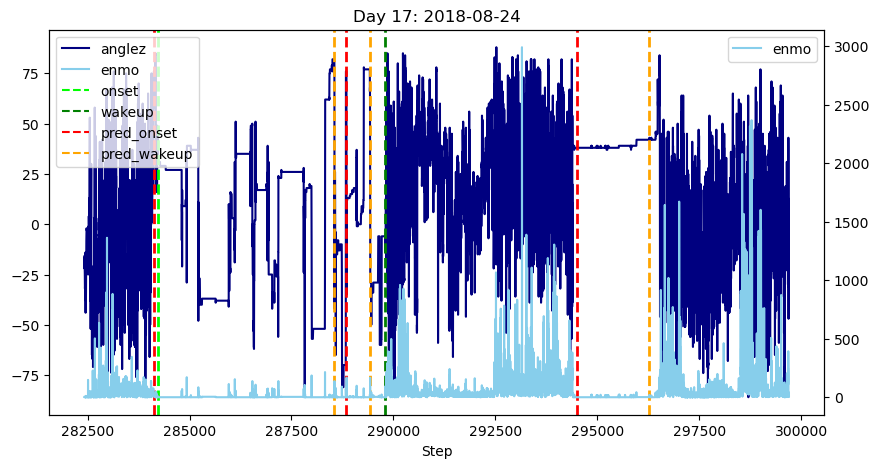

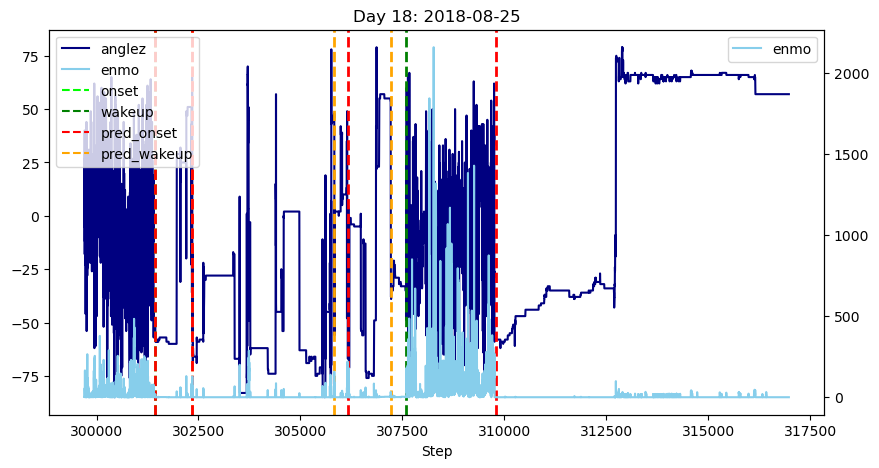

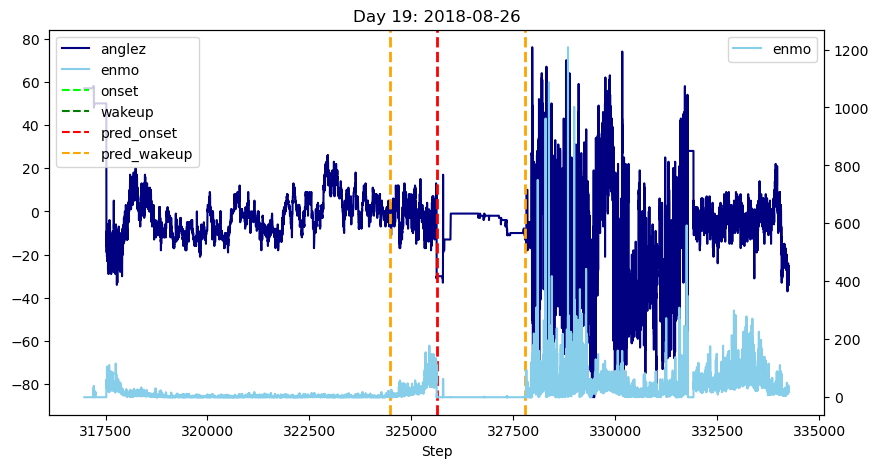

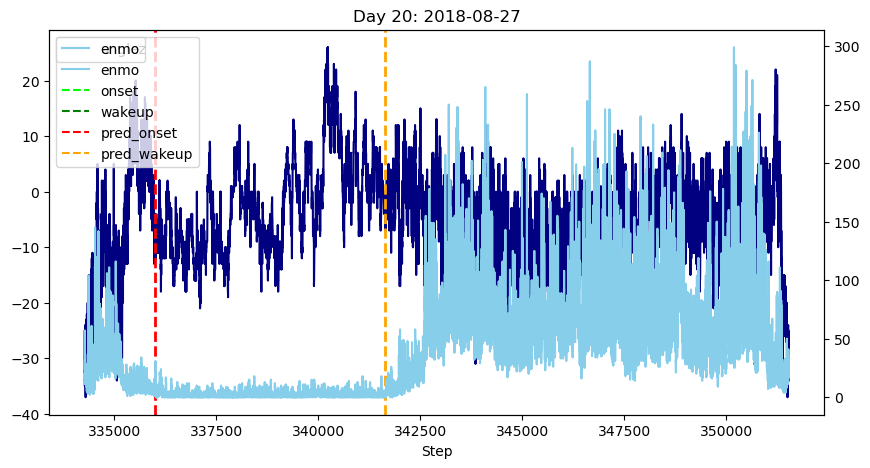

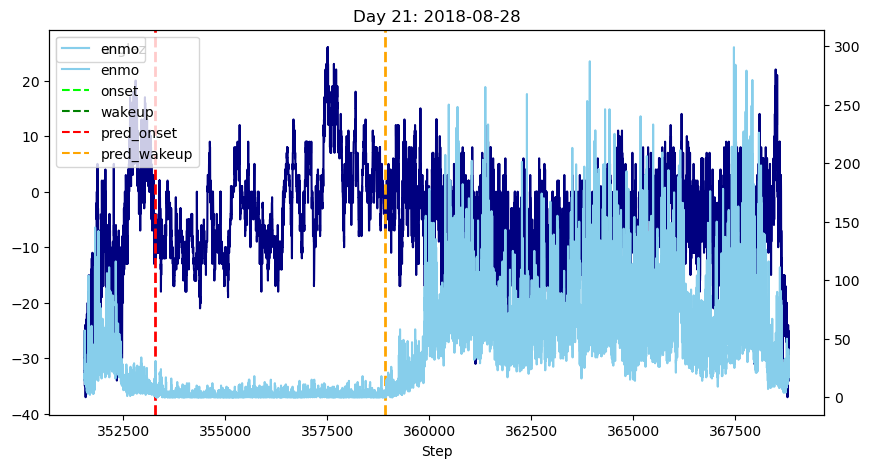

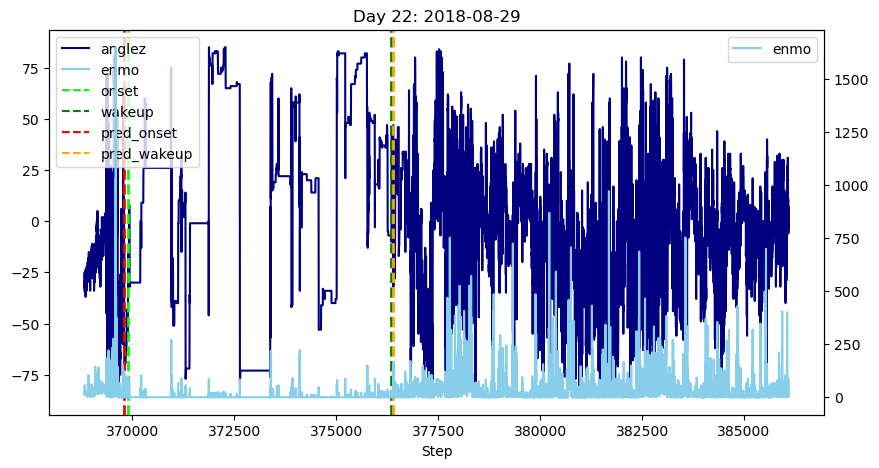

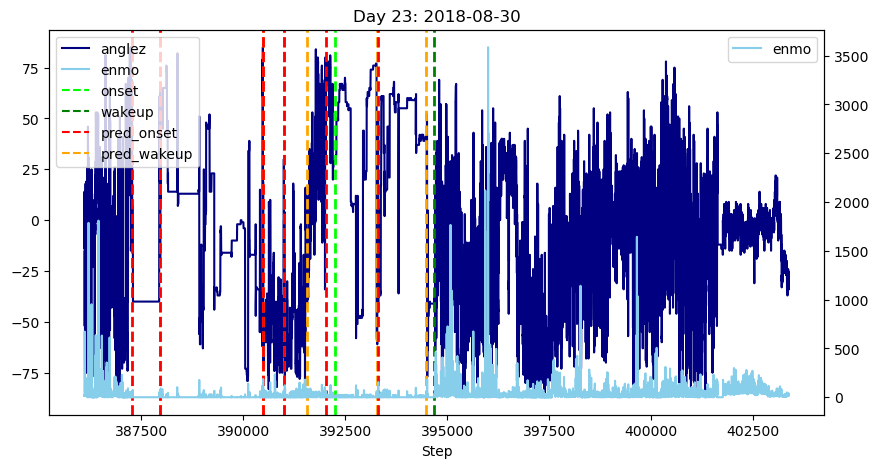

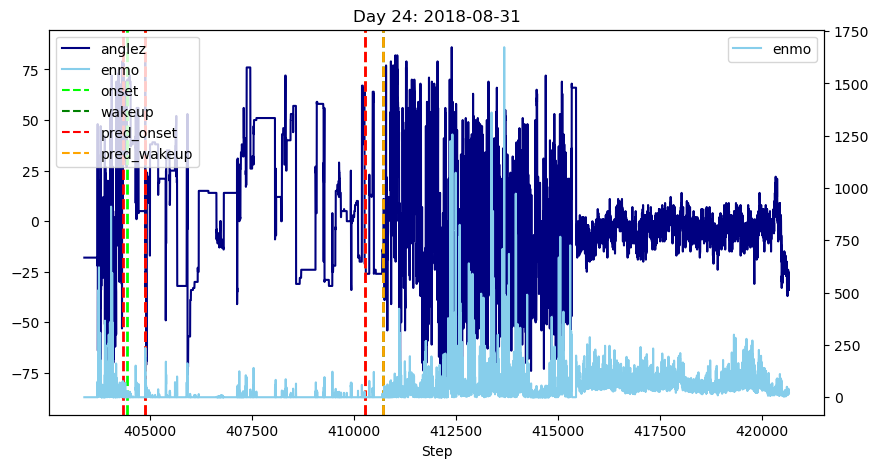

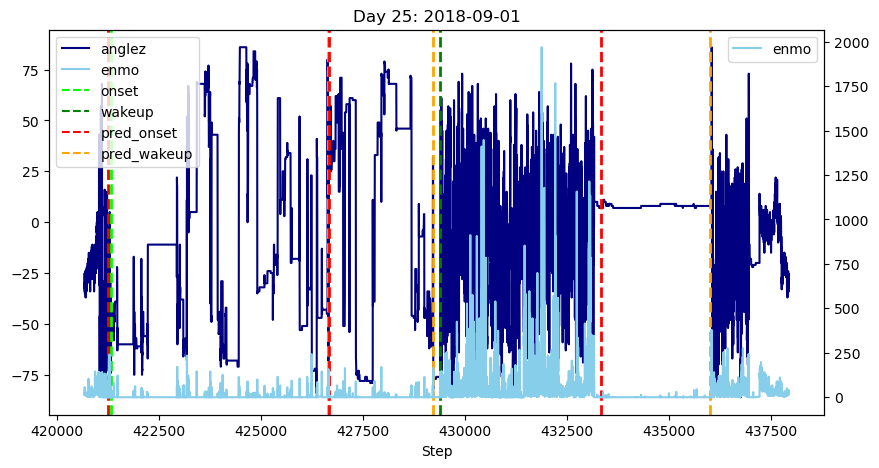

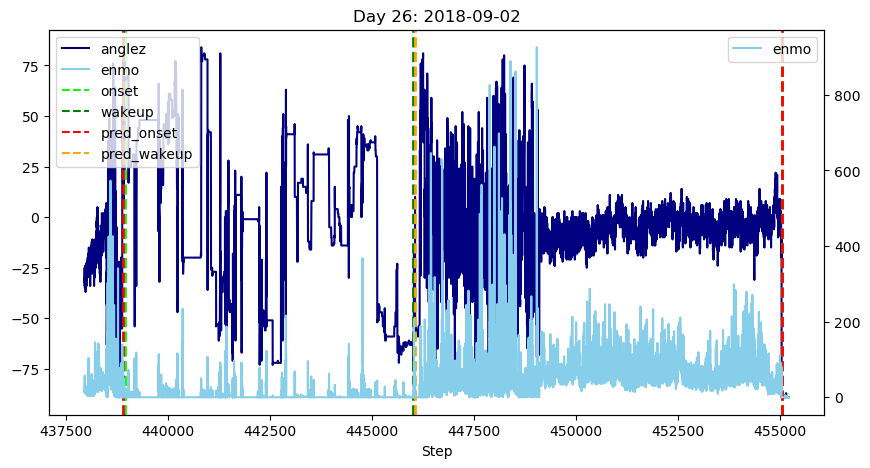

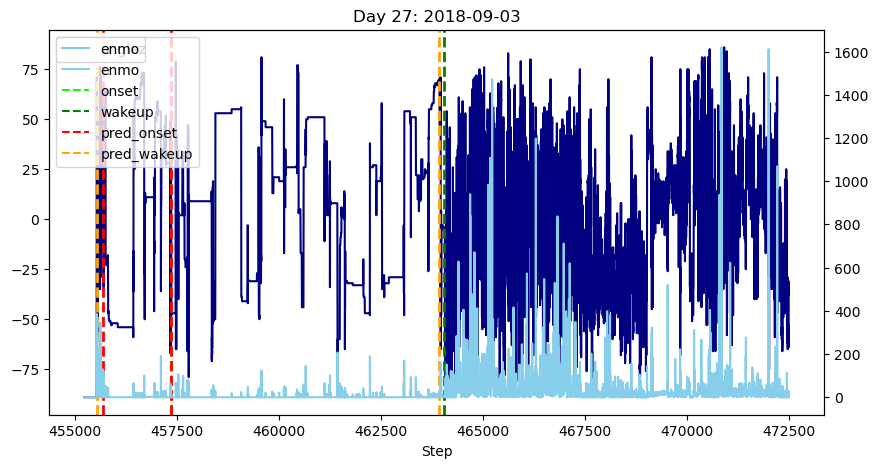

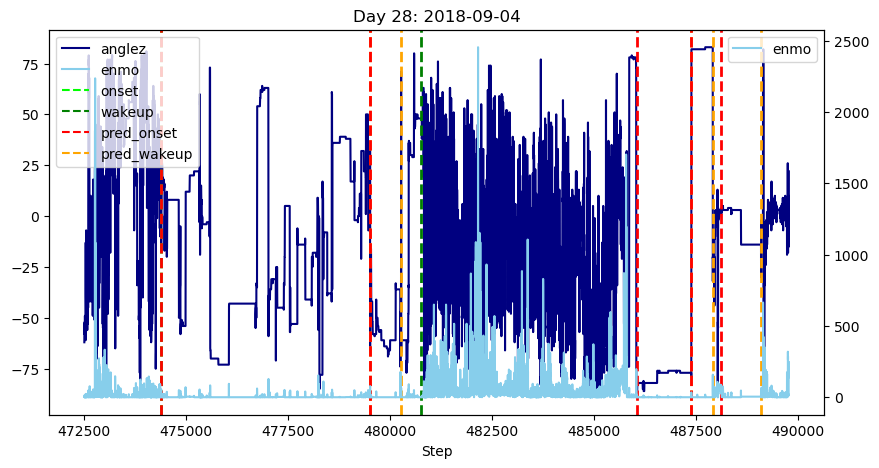

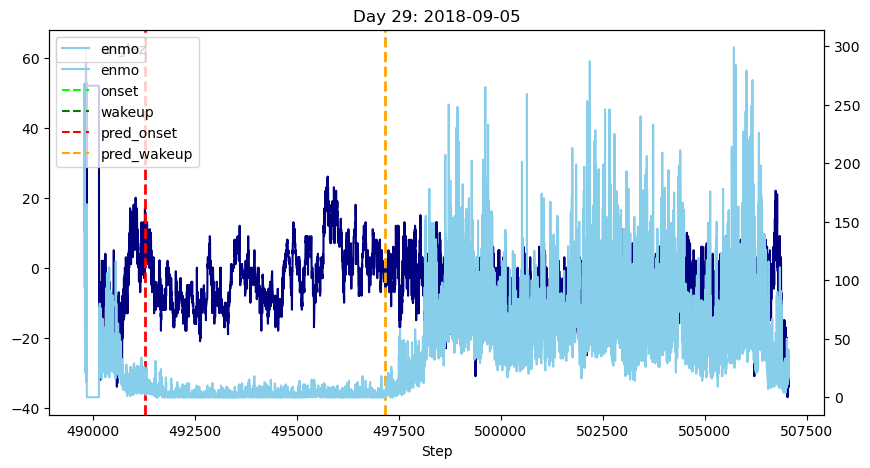

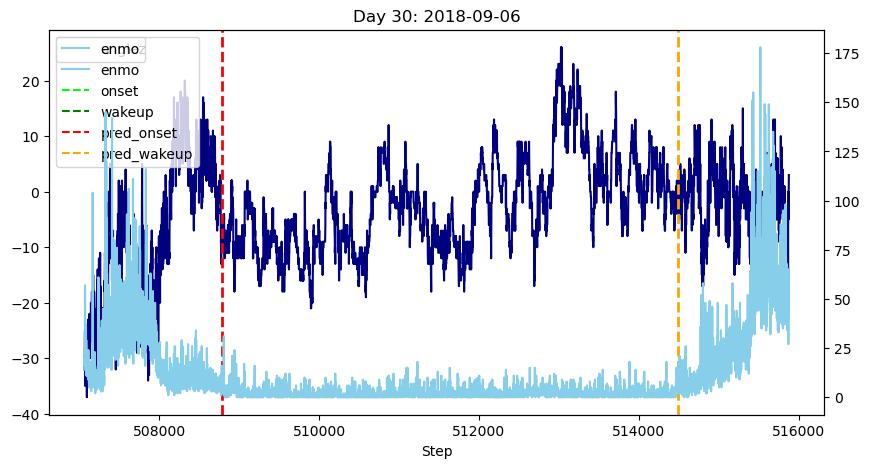

In [ ]:
from matplotlib.lines import Line2D

# get rows of first user in the val data
user_id = val_subset[['series_id']].values[0][0]
val_example = val_subset[val_subset['series_id'] == user_id]

# get events for the user
example_events = train_events[train_events['series_id'] == user_id]

# create date col
val_example['date'] = val_example['timestamp'].dt.date

# get rows from preds for the example user
user_preds = val_event_preds[val_event_preds['series_id'] == user_id]



# iterate through each date and row of data for the user
for i, (date, row) in enumerate(val_example.groupby('date')):

    # get first and last step for each date
    min_step = row['step'].min()
    max_step = row['step'].max()

    # plot anglez
    fig, ax = plt.subplots(figsize=(10, 5))
    row.set_index('step')[['anglez']].plot(ax=ax, title=f'Day {i}: {date}', color='navy', label='anglez')
    ax.set_xlabel('Step')

    # plot enmo
    ax2 = ax.twinx()
    row.set_index('step')[['enmo']].plot(ax=ax2, color='skyblue', label='enmo')

    # get the onset and wakeup events for the day
    user_events = example_events.loc[(example_events['step'] >= min_step) & (example_events['step'] <= max_step)].reset_index(drop=True)

    # plot vertical lines for events
    for index, event in user_events.iterrows():
        if event['event'] == 'onset':
            ax.axvline(x=event['step'], color='lime', linestyle='--', linewidth=2, label='onset')
        elif event['event'] == 'wakeup':
            ax.axvline(x=event['step'], color='green', linestyle='--', linewidth=2, label='wakeup')

    # get the onset and wakeup preds for the day
    day_preds = user_preds.loc[(user_preds['step'] >= min_step) & (user_preds['step'] <= max_step)].reset_index(drop=True)
    
    # plot vertical lines for preds
    for index, event in day_preds.iterrows():
        if event['event'] == 'onset':
            ax.axvline(x=event['step'], color='red', linestyle='--', linewidth=2, label='pred_onset')
        elif event['event'] == 'wakeup':
            ax.axvline(x=event['step'], color='orange', linestyle='--', linewidth=2, label='pred_wakeup')
    
    # custom legends
    legend_elements = [Line2D([0], [0], color='navy', label='anglez'),
                       Line2D([0], [0], color='skyblue', label='enmo'),
                       Line2D([0], [0], color='lime', linestyle='--', label='onset'),
                       Line2D([0], [0], color='green', linestyle='--', label='wakeup'),
                       Line2D([0], [0], color='red', linestyle='--', label='pred_onset'),
                       Line2D([0], [0], color='orange', linestyle='--', label='pred_wakeup')]

    # add legend manually
    ax.legend(handles=legend_elements, loc='upper left')
    
    plt.show()

In this original implementation, our model has a propensity to predict 

In [ ]:
user_preds[90:]

,row_id,series_id,step,event,score,date
90,90,0f572d690310,390997,onset,0.874,2018-08-30
91,91,0f572d690310,391555,wakeup,0.874,2018-08-30
92,92,0f572d690310,392017,onset,0.936,2018-08-30
93,93,0f572d690310,393268,wakeup,0.936,2018-08-30
94,94,0f572d690310,393311,onset,0.895,2018-08-30
95,95,0f572d690310,394478,wakeup,0.895,2018-08-30
96,96,0f572d690310,404337,onset,0.886,2018-08-31
97,97,0f572d690310,404875,wakeup,0.886,2018-08-31
98,98,0f572d690310,404876,onset,0.976,2018-08-31
99,99,0f572d690310,410252,wakeup,0.976,2018-08-31


In [ ]:
# add date column to events
# date = X[(X['step'] >= onset) & (X['step'] < wakeup)]['timestamp'].dt.date.iloc[0]

# only take the two rows for each date where score is the highest
# events = events.sort_values('score', ascending=False).groupby(['series_id', 'event', 'date']).head(2)

# Submission

In [ ]:
# fit on entire training set


In [ ]:
# get event predictions
# submission = get_events(test_series, classifier)
# submission.drop('date', axis=1).to_csv('submission.csv', index=False)